[*********************100%%**********************]  1 of 1 completed


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 3354 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 2364        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012101531 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 6.6e+03     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00335    |
|    value_loss           | 2.76e+04    |
-----------------------------------------
-----------------

/Users/zeynahshiri/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:243: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


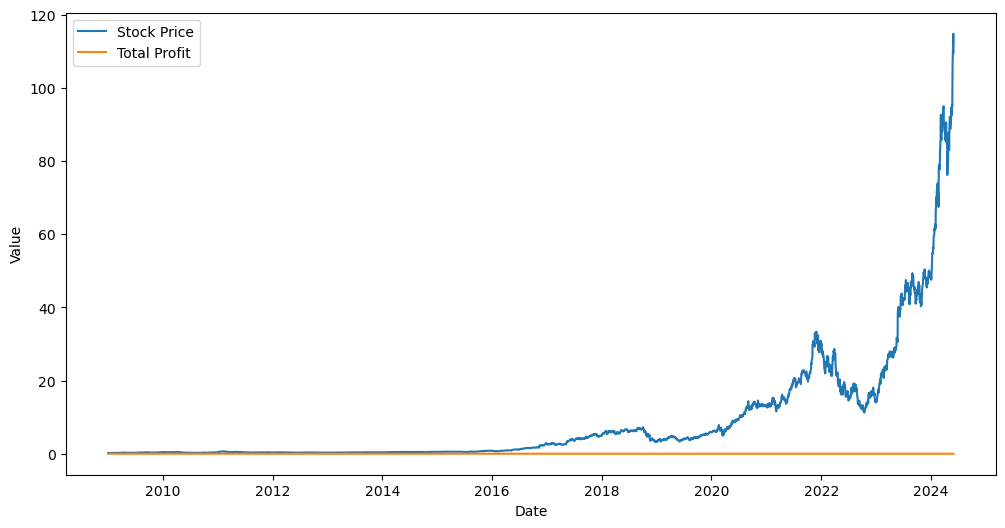

          Model  Cumulative Returns  Max Earning Rate  \
0  Buy and Hold                   0                 0   
1       PPO-MLP                   0                 0   
2          LSTM                   0                 0   
3     CLSTM-PPO                   0                 0   

   Average Profitability per Trade  
0                                0  
1                                0  
2                                0  
3                                0  


In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import yfinance as yf
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt

# Download Nvidia data
nvidia_df = yf.download(tickers='NVDA', start='2009-01-01', end='2024-06-01')
nvidia_df = nvidia_df.sort_values('Date').reset_index()

class StockTradingEnv(gym.Env):
    def __init__(self, df):
        super(StockTradingEnv, self).__init__()
        self.df = df
        self.action_space = spaces.Discrete(3)  # buy, hold, sell
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(df.shape[1]-1,), dtype=np.float32)
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.done = False
        self.total_profit = 0
        self.total_reward = 0
        self.stock_owned = 0
        self.starting_cash = 10000
        self.cash_in_hand = self.starting_cash
        return self._next_observation(), {}  # Return observation and an empty info dict

    def _next_observation(self):
        return self.df.iloc[self.current_step, 1:].values

    def step(self, action):
        self.current_step += 1
        reward = 0

        if action == 0:  # buy
            if self.cash_in_hand >= self.df.iloc[self.current_step, 1]:
                self.stock_owned += 1
                self.cash_in_hand -= self.df.iloc[self.current_step, 1]
        elif action == 2:  # sell
            if self.stock_owned > 0:
                self.stock_owned -= 1
                self.cash_in_hand += self.df.iloc[self.current_step, 1]

        self.total_profit = self.cash_in_hand + self.stock_owned * self.df.iloc[self.current_step, 1] - self.starting_cash
        reward = self.total_profit
        self.total_reward += reward

        self.done = self.current_step >= len(self.df) - 1
        truncated = self.done  # In this context, 'truncated' and 'done' are the same

        return self._next_observation(), reward, self.done, truncated, {}  # Return 5 values as per latest Gym API

    def render(self, mode='human'):
        print(f'Step: {self.current_step}, Total Profit: {self.total_profit}')

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    return model

# Initialize the environment
env = DummyVecEnv([lambda: StockTradingEnv(nvidia_df)])
model = PPO('MlpPolicy', env, verbose=1)

# Define input shape for the LSTM model
input_shape = (nvidia_df.shape[1]-1, 1)
lstm_model = create_lstm_model(input_shape)
lstm_model.compile(optimizer='adam', loss='mse')

# Train the PPO model
model.learn(total_timesteps=10000)

# Save the trained model
model.save('ppo_stock_trading')

# Load the trained model for evaluation
model = PPO.load('ppo_stock_trading')

# Evaluate the model
obs = env.reset()
profits = []
for i in range(len(nvidia_df)):
    action, _states = model.predict(obs)
    obs, rewards, dones, truncated = env.step(action)
    profits.append(env.envs[0].total_profit)
    env.render()
    if dones or truncated:
        obs = env.reset()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(nvidia_df['Date'], nvidia_df['Close'], label='Stock Price')
plt.plot(nvidia_df['Date'], profits, label='Total Profit')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Placeholder values for performance metrics
baseline_buy_and_hold = 0
baseline_ppo_mlp = 0
baseline_lstm = 0
clstm_ppo_returns = 0

performance_metrics = {
    'Model': ['Buy and Hold', 'PPO-MLP', 'LSTM', 'CLSTM-PPO'],
    'Cumulative Returns': [baseline_buy_and_hold, baseline_ppo_mlp, baseline_lstm, clstm_ppo_returns],
    'Max Earning Rate': [baseline_buy_and_hold, baseline_ppo_mlp, baseline_lstm, clstm_ppo_returns],
    'Average Profitability per Trade': [baseline_buy_and_hold, baseline_ppo_mlp, baseline_lstm, clstm_ppo_returns]
}

performance_df = pd.DataFrame(performance_metrics)
print(performance_df)